In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from time import time
plt.rcParams['figure.figsize'] = (8.0, 8.0)

In [2]:
np.random.seed(0)

In [3]:
def generate_samples(m, b, size=20):
    
    x = np.random.random(size) * 75 + 2
    
    y = m * x + b
    
    y_range = (y.max() - y.min())
    
    sigma = np.random.randn(size) * 0.1 * y_range
    sigma = sigma + 2 * (sigma/abs(sigma))
    y = y + sigma
    
    return x, y, sigma
    
    

In [4]:
x, y, y_err  = generate_samples(0.736, 30)
def plot_data(x, y, y_err):
    plt.figure()
    plt.errorbar(x, y, yerr=y_err, color='black', linestyle='', marker='^', capsize=4)
    plt.xlim([x.min() - 30, x.max() + 30])
    plt.ylim([y.min() - 50, y.max() + 50])
    plt.xlabel("x")
    plt.ylabel("y")



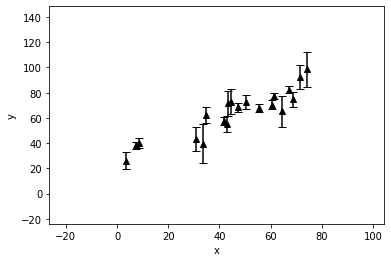

In [5]:

plot_data(x, y, y_err)
plt.show()


Want to find $Pr(m,\, b\, |\, Assumptions)$ 

### posterior distribution (parameter(s) | data) = sampling distribution (data | parameter(s)) * prior distribution ( parameters) / evidence (data)
Note : sampling distribution with known data = likelihood
### Therefore: ln(posterior distribution) = ln(sampling distribution) + ln(prior distribution) - log(evidence)

sampling distribution = gaussian deviation from a straight line equation 

prior distribution = uniform distribution

evidence = will not be considered as it acts as a normalisation factor only.

In [6]:
def natural_log_likelihood(parameters, x, y, error):
    """
    Computes the gaussian of the deviation from the analytic straight line y = mx + b
    
    gauss = 1/(sqrt(2 * pi) * error) * exp(- 0.5 * ((y - m * x - b) ** 2 ) / error)
    ln(gauss) = ln(1/(sqrt(2 * pi) * error)) + (- 0.5 * ((y - m * x - b) ** 2 ) / error)
    
    ln(gauss) needs to then be reduced to a signle probablility via summation
    """
    m, b = parameters

    return (np.sum(np.log(1./(np.sqrt(2.*np.pi) * error))) +
            np.sum(-0.5 * (y - (m*x + b))**2 / error**2))


def log_uniform_prior_dist(parameters, limits):
    """
    returns log of uniform distribution if within limits, -infinity otherwise
    """
    m, b = parameters
    
    mlimits, blimits = limits
    
    if (m >= mlimits[0]) and (m <= mlimits[1]):
        log_uniform_prior_m = np.log(1.0/(mlimits[1] - mlimits[0]))
    else:
        log_uniform_prior_m = -np.inf
    if (b >= blimits[0]) and (b <= blimits[1]):
        log_uniform_prior_b = np.log(1.0/(blimits[1] - blimits[0]))
    else:
        log_uniform_prior_b = -np.inf
        
    return log_uniform_prior_m + log_uniform_prior_b


def natural_log_post_disribution(parameters, x, y, error, param_limits):
    """
    multiplication becomes addition as the log of the probability is taken
    """
    return natural_log_likelihood(parameters, x, y, error) + log_uniform_prior_dist(parameters, param_limits)

Sample values for m and b using the Markov Chain Monte Carlo Methods : The Metropolis Algorithm

Metropolis Algorithm procedure:
1. Sample a point from the posterior distribution
2. Symmetrically sample a second point around the last point
3. IF posterior(x$_{i+1}$) > posterior(x$_{i}$) accept the new point
   ELSE generate a uniform random number (n$_r$) in \[0, 1\] and accept if $\frac{p(x_{i+1})}{p(x_i)} > n_r$
4. Repeat 2 and 3 for N times.

In [7]:
def Metropolis(posterior_function, data, parameters, param_limits, stepsizes, nsteps=10000):
    
    x, y, error = data
    
    # Generating an initial position probability
    log_post = posterior_function(parameters, x, y, error, param_limits)
    # print(log_post)

    markov_chain = np.empty((nsteps, len(parameters)))
    log_probabilities = np.empty(nsteps)
    n_accepted = 0
    
    for i in range(nsteps):
        new_params = parameters + stepsizes * np.random.randn(len(parameters))
        new_log_post = posterior_function(new_params, x, y, error, param_limits)
        # print(new_log_post)
        if new_log_post > log_post:
            parameters = new_params
            log_post = new_log_post
            n_accepted += 1
        else:
            n_rand = np.log(np.random.random())
            if n_rand < (new_log_post - log_post):
                parameters = new_params
                log_post = new_log_post
                n_accepted += 1
            else:
                pass
        markov_chain[i] = parameters
        log_probabilities[i] = log_post
        
    acceptance = n_accepted / nsteps
    return markov_chain, log_probabilities, acceptance

    

In [65]:
start_parameters = np.array([0.5, 10])
mlimits, blimits = ((0.01, 2), (0.1, 50))

stepsize_m = 0.02 * (mlimits[1] - mlimits[0])
stepsize_b = 0.05 * (blimits[1] - blimits[0])

stepsize = np.array([stepsize_m, stepsize_b])

data = (x, y, abs(y_err))

print("Sampling using Metropolis Algorithm")

t = time()
for i in range(50):
    chain, log_probs, acceptance = Metropolis(natural_log_post_disribution, data, start_parameters, (mlimits, blimits), stepsize, nsteps=10000)
t = (time() - t) / 50
print(f"Ran with acceptance rate of {acceptance} in {t} seconds average")


Sampling using Metropolis Algorithm
Ran with acceptance rate of 0.3306 in 0.6845327711105347 seconds average


In [9]:
def plot_chain(chain, mlimits, blimits):
    fig, ax = plt.subplots(2, 1)
    ax[0].plot(chain[:, 0], 'k-')
    ax[0].set_ylabel("Gradient of data (m)")
    ax[0].set_ylim(*mlimits)
    ax[0].set_xticks([])
    ax[1].set_ylabel("Intercept of data (b)")
    ax[1].set_ylim(*blimits)
    ax[1].set_xlabel("Sample Number")
    ax[1].plot(chain[:, 1], 'k-')

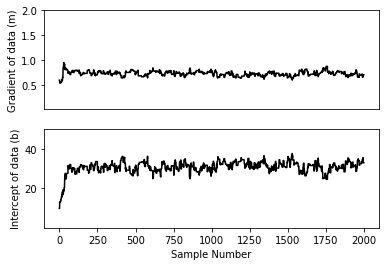

In [10]:
plot_chain(chain, mlimits, blimits)
plt.show()

In [11]:
def plot_PDF_walk(chain, start_parameters, mlimits, blimits, title="MCMC: Posterior PDF for parameters m and b"):
    plt.figure()
    plt.plot(chain[:, 1], chain[:, 0], linestyle="", marker='H', alpha=0.01, color="blue")
    plt.plot(start_parameters[1], start_parameters[0], linestyle="", marker='H', alpha=1, color="red", label="RW Starting Position")
    plt.ylim(*mlimits)
    plt.xlim(*blimits)
    plt.title(title)
    plt.legend()
    plt.ylabel("Gradient of data (m)")
    plt.xlabel("Intercept of data (b)")


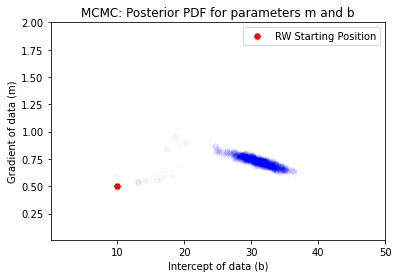

In [12]:
plot_PDF_walk(chain, start_parameters, mlimits, blimits, title="MCMC: Posterior PDF for parameters m and b")
plt.show()

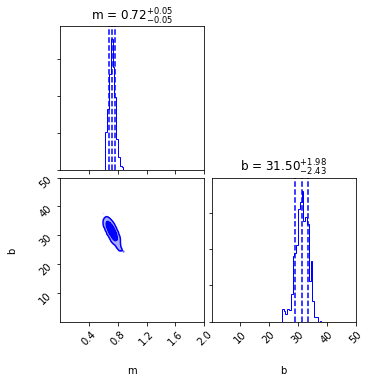

In [13]:
import corner
corner.corner(chain[500:], labels=['m','b'], range=[mlimits,blimits],quantiles=[0.16,0.5,0.84],
                show_titles=True, title_args={"fontsize": 12},
                plot_datapoints=True, fill_contours=True, levels=[0.68, 0.95], 
                color='b', bins=80, smooth=1.0);

Performed estimates using corner and extracted the median values of the simulated parameter distributions.

The estimates are incredibly accurate as $m_{estimated} = 0.72 \pm 0.05$, compared to a true value of $m = 0.736$;  and $b_{estimated} = 31.50 (+1.98, -2.43)$, compared to a true value of $b=30$. Both are with estimated error range.

## Check the Model

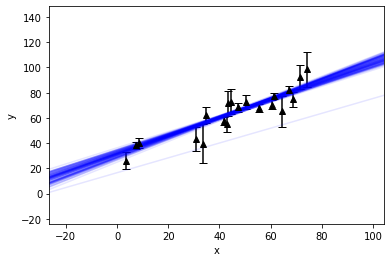

In [14]:
x_axis = np.linspace(x.min() - 30, x.max() + 30, 50)

plot_data(x, y, y_err)

for i in np.random.randint(len(chain), size=100):
    m, b = chain[i]
    plt.plot(x_axis, m* x_axis + b, color='blue', alpha=0.1)
plt.show()

# Performing the same procedure using a Fortran engine

In [15]:
# !rm FortranEngine.cpython-36m-x86_64-linux-gnu.so 
# !f2py3 engine.f90 -m FortranEngine -c

In [16]:
import FortranEngine
print(dir(FortranEngine))

['_FortranEngine_error', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', '__version__', 'data_generator', 'mcmc', 'probability']


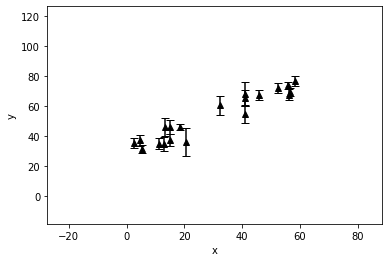

In [73]:
m, b = (0.736, 30)
x, y, y_err = FortranEngine.data_generator.generate_data(m, b, 20)

plot_data(x, y, y_err)
plt.show()

#### Comparing the between the Python functions and the Fortran engine, gives us an indication of the uncertainty that arises from the choice of technology

In [74]:
out= FortranEngine.probability.log_likelihood(np.array([m, b]), x, y, y_err, 20)
print(out)

-56.51816177368164


In [75]:
out2 = natural_log_likelihood(np.array([m, b]), x, y, abs(y_err))
print(out2)

-56.518166


In [76]:
print(abs(out - out2) / abs(out) * 100)

6.749506965389945e-06


In [77]:
parameters = np.array([2, 0.5])
limits = np.array([[0, 4],
                  [0, 1]])
out = FortranEngine.probability.ln_uniform_prior_dist(parameters, limits)
print(out)

-1.3862943649291992


In [78]:
out2 = log_uniform_prior_dist(parameters, limits)
print(out2)

-1.3862943611198906


In [79]:
print(abs(out - out2) / abs(out) * 100)

2.747835339063086e-07


In [80]:
parameters = np.array([2, 0.5])
limits = np.array([[0, 4],
                  [0, 1]])
out = FortranEngine.probability.ln_posterior_dist(parameters, x, y, y_err, limits, 20)
print(out)

-692.7340698242188


In [81]:
out2 = natural_log_post_disribution(parameters, x, y, abs(y_err), limits)
print(out2)

-692.7340726814324


In [82]:
print(abs(out - out2) / abs(out) * 100)

4.124546155312138e-07


#### The uncertainty is negligible in all cases. We can now run our simulation using the Fortran Engine!

In [83]:
start_parameters = np.array([0.5, 10])
# mlimits, blimits = ((0.01, 2), (0.1, 50))
limits = np.array([[0.01, 2.0],
                  [0.1, 50.0]])
stepsize_m = 0.02 * (limits[0, 1] - limits[0, 0])
stepsize_b = 0.05 * (limits[1, 1] - limits[1, 0])

stepsize = np.array([stepsize_m, stepsize_b])
data = (x, y, abs(y_err))


t = time()
for i in range(50):
    chain, probs, acceptance = FortranEngine.mcmc.metropolis(data, start_parameters, limits, stepsize, 10000, 20)
t = (time() - t) / 50

print(f"The MCMC simulation ran with an acceptance rate of {acceptance} in {t} seconds average")

The MCMC simulation ran with an acceptance rate of 0.2596000134944916 in 0.2828431272506714 seconds average


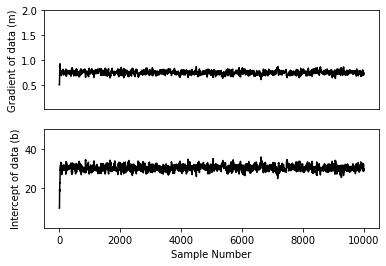

In [84]:
plot_chain(chain, *limits)
plt.show()

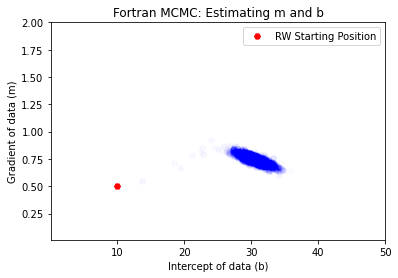

In [85]:
plot_PDF_walk(chain, start_parameters, limits[0], limits[1], title="Fortran MCMC: Estimating m and b")
plt.show()

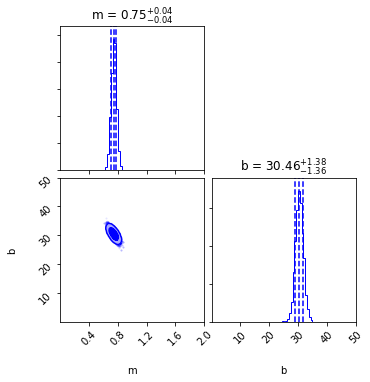

In [86]:
corner.corner(chain[500:], labels=['m','b'], range=[mlimits,blimits],quantiles=[0.16,0.5,0.84],
                show_titles=True, title_args={"fontsize": 12},
                plot_datapoints=True, fill_contours=True, levels=[0.68, 0.95], 
                color='b', bins=80, smooth=1.0);